In [1]:
%matplotlib inline
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, SimpleRNN
from keras.layers import SpatialDropout1D, GRU
from keras.layers.wrappers import Bidirectional

from keras.layers.normalization import BatchNormalization


from keras.layers import Average, Flatten, Masking
from keras.models import Model, Sequential
from keras.layers import Dense, Input

from keras.layers import merge, Multiply
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
import keras.backend as K


from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score

/home/linewalks/anaconda3/envs/tf-1.10/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
# https://github.com/philipperemy/keras-attention-mechanism

def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations


def attention_3d_block(inputs):
    time_steps, input_dim = map(int, inputs.shape[1:])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, time_steps))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(time_steps, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul


def model_attention_applied_before_lstm(shape):
    time_steps, input_dim = shape[1:]
    inputs = Input(shape=(time_steps, input_dim,))
    attention_mul = attention_3d_block(inputs)
    masking = Masking(mask_value=0.0)(attention_mul)

    lstm_units = 128
    attention_mul = LSTM(lstm_units, return_sequences=False)(masking)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model


def model_attention_applied_before_lstm_day_cls(shape):
    time_steps, input_dim = shape[1:]
    inputs = Input(shape=(time_steps, input_dim,))
    attention_mul = attention_3d_block(inputs)
    masking = Masking(mask_value=0.0)(attention_mul)

    lstm_units = 128
    attention_mul = LSTM(lstm_units, return_sequences=False)(masking)
    output = Dense(time_steps, activation='softmax')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model


def get_df_by_hadm_id(x, hadm_id):
    idx = pd.IndexSlice
    hadm_1 = x.loc[idx[:, hadm_id, :], :].copy()
    return hadm_1


def get_op_day(y, label_name):
    def get_opday(r):

        if r.any():
            return np.argmax(r.values) + 1
        else:
            return r.count()
    op_daily = y[[label_name]].reset_index(level=2)
    op_daily.columns = ['day', label_name]
    op_nth_day = op_daily.pivot_table(values=label_name, index='hadm_id', columns='day', aggfunc='sum')
    return op_nth_day.apply(get_opday, axis=1)


def get_timesteped_X(x, maxlen):
    hadm_list = x.index.levels[1]

    inputs = [None] * len(hadm_list)
    for i, hadm_id in enumerate(hadm_list):
        h = get_df_by_hadm_id(x, hadm_id)
        inputs[i] = h.values
    X = pad_sequences(inputs, maxlen=maxlen, dtype='float32', padding='post', truncating='post')
    return X


def get_merged_Xy(x, y, label_name, maxlen):
    y = y.copy()
    y = y.reset_index()[['hadm_id',label_name]].groupby('hadm_id')[[label_name]].agg('sum')
    y = (y[label_name] > 0).astype(int).values.reshape(-1, 1)
    X = get_timesteped_X(x, maxlen)
    return X, y


def get_daily_Xy(x, y, label_name, maxlen):
    y = y.copy()
    y = y[['op']].reset_index(level=2).pivot_table(values='op', index='hadm_id', columns='rno', aggfunc='sum').loc[:, :maxlen]
    y = y.fillna(False)
    X = get_timesteped_X(x, maxlen)

    # only who got surgery within 7 days after admission
    op_mask = y.any(axis=1)
    X = X[op_mask]
    y = y[op_mask]
    hadm_list = y.index
    return X, y.values, hadm_list

In [3]:
filename_mimiciii_ts = "mimiciii_daily_label_op.h5"
with pd.HDFStore(filename_mimiciii_ts) as hdf:
    print(hdf.keys())

['/meta', '/x', '/y']


In [4]:
meta = pd.read_hdf(filename_mimiciii_ts, key='meta')
x = pd.read_hdf(filename_mimiciii_ts, key='x')
y = pd.read_hdf(filename_mimiciii_ts, key='y')
d_evt_map = {str(k):v for k, v in zip(meta.event_id.tolist(), meta.event_name.tolist())}
op_day = get_op_day(y, 'op') 

# remove columns might be hint to predict surgery(e.g. CSRU, Cardiac surgery recovery unit)
# also remove columns clinically unrelevant (admission types)
leak_cols = meta[meta.category.str.contains("icu") | meta.category.str.contains("admit")].event_id.tolist()
excluded_cols = list(set(x.columns.tolist()) & set(map(str, leak_cols)))

x = x.drop(excluded_cols, axis=1)

# Reshaping X, y

- X1, y1: (number of unique hadm_id, timestep(rno), features), (number of unique hadm_id, 1)
- X2, y2: (number of unique hadm_id, timestep(rno), features), (number of unique hadm_id, timestep(rno))

In [5]:
X1, y1 = get_merged_Xy(x, y, label_name='op', maxlen=7)

In [6]:
X2, y2, y2_hadm_list = get_daily_Xy(x, y, label_name='op', maxlen=7)

In [7]:
print(X1.shape, y1.shape)

(22495, 7, 231) (22495, 1)


In [8]:
print(X2.shape, y2.shape)

(2795, 7, 231) (2795, 7)


# LSTM with attention - train

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.33, random_state=10)

# train1 - Predict whether a patient will undergo surgery


In [21]:
m1 = model_attention_applied_before_lstm(shape=X1.shape)

opt = optimizers.Adam(0.0055, beta_1=0.9, beta_2=0.9, amsgrad=False)
m1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(m1.summary())
m1.fit([X_train], y_train, epochs=5, batch_size=64, validation_split=0.1)

/home/linewalks/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/ipykernel/__main__.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 7, 231)       0                                            
__________________________________________________________________________________________________
permute_3 (Permute)             (None, 231, 7)       0           input_3[0][0]                    
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 231, 7)       0           permute_3[0][0]                  
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 231, 7)       56          reshape_3[0][0]                  
__________________________________________________________________________________________________
attention_

In [22]:
y_pred = m1.predict(X_test)
print('AUROC score:    %f' % roc_auc_score(y_test, y_pred))
print('F1 score:       %f' % f1_score(y_test, (y_pred > 0.5)))
print('Accuracy score: %f' % accuracy_score(y_test, (y_pred > 0.5)))



AUROC score:    0.970453
F1 score:       0.815690
Accuracy score: 0.953798


# train2 - Predict how many days after hospitalization a patient will undergo surgery

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.33, random_state=10)

In [14]:
m2 = model_attention_applied_before_lstm_day_cls(shape=X2.shape)

opt = optimizers.Adam(0.004, beta_1=0.7, beta_2=0.9, amsgrad=False)
m2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(m2.summary())
m2.fit([X_train], y_train, epochs=10, batch_size=64, validation_split=0.1)

/home/linewalks/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 7, 231)       0                                            
__________________________________________________________________________________________________
permute_2 (Permute)             (None, 231, 7)       0           input_2[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 231, 7)       0           permute_2[0][0]                  
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 231, 7)       56          reshape_2[0][0]                  
__________________________________________________________________________________________________
attention_

In [15]:
y_pred = np.argmax(m2.predict(X_test), axis=1)
answer = np.argmax(y_test, axis=1)

print('Confusion matrix:')
print(confusion_matrix(answer, y_pred))
print('F1 score: %f' % f1_score(answer, y_pred, average='macro'))
print('Accuracy score: %f' % accuracy_score(answer, y_pred))

Confusion matrix:
[[217  35  42  17   9   2   5]
 [ 79  78   7   5   0   1   1]
 [ 26   2 110   1   7   0   0]
 [ 12   2   2  77   1   0   0]
 [ 14   0   6   0  52   3   3]
 [ 11   1   3   0   8  30   3]
 [ 10   1   9   0   4   0  27]]
F1 score: 0.648356
Accuracy score: 0.640303


# LSTM with attention - performance, weights viz


In [16]:
attention_vectors = get_activations(m2,
                                    X2,
                                    print_shape_only=True,
                                    layer_name='attention_vec')[0]

----- activations -----
(2795, 7, 231)


### Attention vector of all patients

/home/linewalks/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


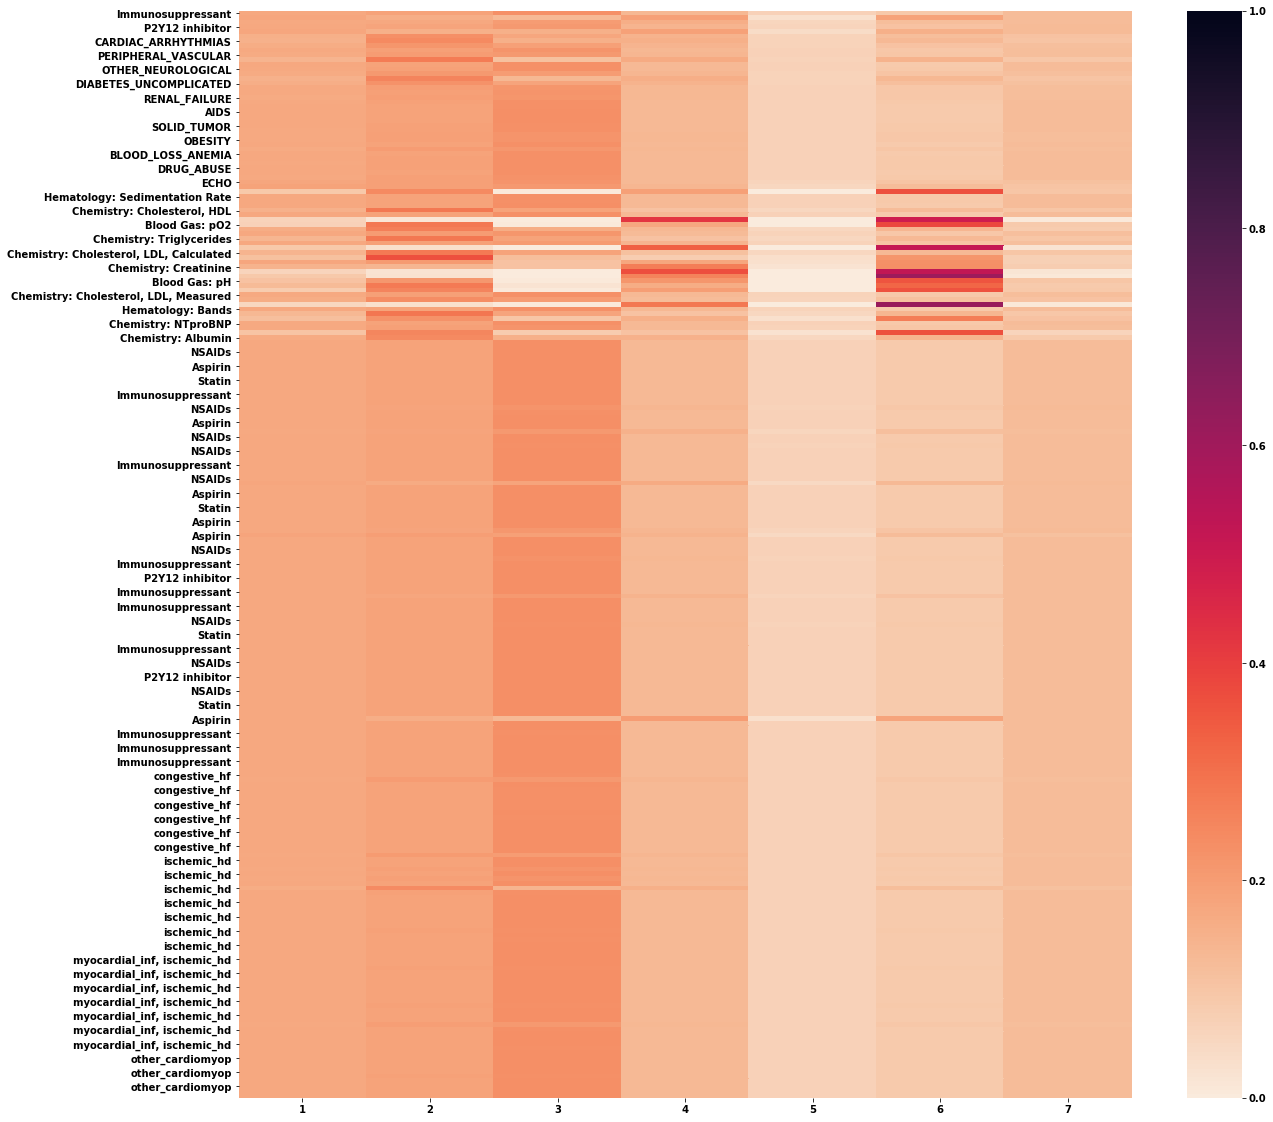

In [17]:
plt.figure(figsize=(20,20))
avec = pd.DataFrame(np.mean(attention_vectors, axis=0), columns=[d_evt_map[c] for c in x.columns]).T
avec.columns = list(range(1, 8))
sns.heatmap(avec, cmap=sns.cm.rocket_r, vmin=0.0, vmax=1.0)

### Attention vector of a patient

In [18]:
import random

hadm_id = random.choice(y2_hadm_list)
hi = np.where(y2_hadm_list == hadm_id)[0][0]
print(f"{hadm_id} admissions's attention_vectors is at {hi} and did cardiac surgery {op_day[hadm_id]} day(s) after admission.")

181185 admissions's attention_vectors is at 2244 and did cardiac surgery 2 day(s) after admission.


/home/linewalks/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


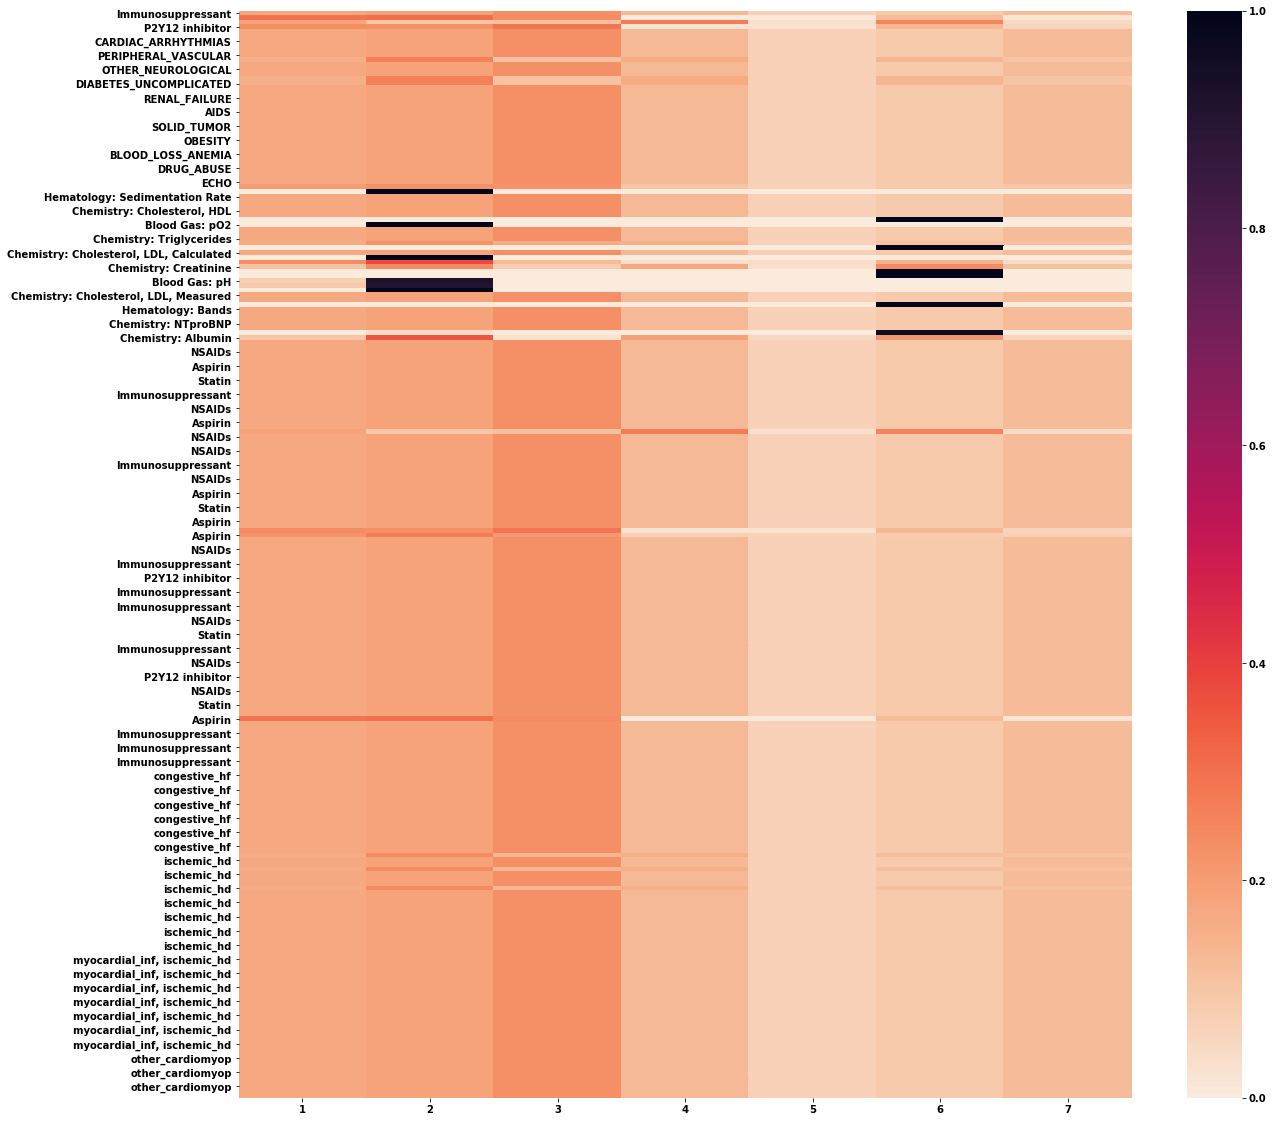

In [19]:
plt.figure(figsize=(20,20))
pvec = pd.DataFrame(attention_vectors[hi], columns=[d_evt_map[c] for c in x.columns]).T
pvec.columns = list(range(1, 8))
sns.heatmap(pvec, cmap=sns.cm.rocket_r, vmin=0.0, vmax=1.0)